# What is satisfaction for a programmer?

## Analyzing Stack Overflow's annual Developer [Surveys](https://insights.stackoverflow.com/survey)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999

#### Setup surveys dictionary for an easy access to all the surveys' data

In [41]:
surveys = {
    "2011": {
        "data": "2011 Stack Overflow Survey Results/2011 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2012": {
        "data": "2012 Stack Overflow Survey Results/2012 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2013": {
        "data": "2013 Stack Overflow Survey Responses/2013 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2014": {
        "data": "2014 Stack Overflow Survey Responses/2014 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2015": {
        "data": "2015 Stack Overflow Developer Survey Responses/2015 Stack Overflow Developer Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2016": {
        "data": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv",
        "readme": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/READ_ME_-_The_Public_2016_Stack_Overflow_Developer_Survey_Results.txt",
        "schema": None
    },
    "2017": {
        "data": "developer_survey_2017/survey_results_public.csv",
        "readme": "developer_survey_2017/README_2017.txt",
        "schema": "developer_survey_2017/survey_results_schema.csv"
    },
    "2018": {
        "data": "developer_survey_2018/survey_results_public.csv",
        "readme": "developer_survey_2018/README_2018.txt",
        "schema": "developer_survey_2018/survey_results_schema.csv"
    },
    "2019": {
        "data": "developer_survey_2019/survey_results_public.csv",
        "readme": "developer_survey_2019/README_2019.txt",
        "schema": "developer_survey_2019/survey_results_schema.csv"
    },
    "2020": {
        "data": "developer_survey_2020/survey_results_public.csv",
        "readme": "developer_survey_2020/README_2020.txt",
        "schema": "developer_survey_2020/survey_results_schema.csv"
    }
}

#### Setup functions for searching columns for keywords

In [42]:
def search_schema(df, string):
    """Search schema's DataFrame columns 'Question' for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        DataFrame containing labels and questions with the matched word.
    """
    if 'Question' in df.columns:
        return df[df['Question'].str.contains('\W*'+string+'\W*', case=False, regex=True)]
    return df[df['QuestionText'].str.contains('\W*'+string+'\W*', case=False, regex=True)]

def search_columns(df, string):
    """Search DataFrame's columns for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        List containing all the columns with the word match.
    """
    return df.columns[df.columns.str.contains('\W*'+string+'\W*', case=False, regex=True)].tolist()

In [5]:
# This is example how `search_schema` works and the description of a column with the subject of study "LanguageWorkedWith"
search_schema(pd.read_csv(surveys['2020']['schema']), 'lang')

,Column,QuestionText
21,LanguageDesireNextYear,"Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
22,LanguageWorkedWith,"Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
32,NEWLearn,How frequently do you learn a new language or framework?


In [6]:
# Description of a column with the subject of study "JobSat"
search_schema(pd.read_csv(surveys['2020']['schema']), 'sat')

,Column,QuestionText
5,CompFreq,"Is that compensation weekly, monthly, or yearly?"
6,CompTotal,"What is your current total compensation (salary, bonuses, and perks, before taxes and deductions), in `CurrencySymbol`? Please enter a whole number in the box below, without any punctuation. If you are paid hourly, please estimate an equivalent weekly, monthly, or yearly salary. If you prefer not to answer, please leave the box empty."
18,JobFactors,"Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?"
19,JobSat,"How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)"


In [51]:
search_schema(pd.read_csv(surveys['2017']['schema']), 'Overpaid')

,Column,Question


In [48]:
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)
survey_2017.shape

(51392, 154)

In [8]:
# This is example how `search_columns` works and all the columns in the data set containing substring "sat" in their names
search_columns(survey_2017, 'sat')

['CareerSatisfaction',
 'JobSatisfaction',
 'AssessJobCompensation',
 'EquipmentSatisfiedMonitors',
 'EquipmentSatisfiedCPU',
 'EquipmentSatisfiedRAM',
 'EquipmentSatisfiedStorage',
 'EquipmentSatisfiedRW',
 'StackOverflowSatisfaction']

### What does it feel like to earn 10k or 200k as a programmer? Let's explore!

While inspecting data sets my attention was caught by "Overpaid" column, *latest data set that "Overpaid" column is 2017*

#### Setup functions for cleaning 2017 dataset

In [9]:
intervals = [i for i in range(10000, 100001, 10000)] + [i for i in range(120000, 200001, 20000)]

def process_salary(df):
    dataframe = df.copy()
    dataframe = dataframe.dropna(subset=['Salary'], axis=0)
    # Rounding salary to the closest integer on the 'intervals' scale.
    dataframe['Salary'] = dataframe['Salary'].apply(lambda x: intervals[np.argmin(abs(np.array(intervals) - x))])
    return dataframe

def process_overpaid(df):
    dataframe = df.copy()
    dataframe['Overpaid'] = dataframe['Overpaid'].fillna('Not sure')
    return dataframe

def make_dummies(df, col):
    dataframe = pd.get_dummies(df, columns=[col])
    return dataframe

In [10]:
survey_2017_clean = survey_2017.copy()
survey_2017_clean = process_salary(survey_2017_clean)
survey_2017_clean = process_overpaid(survey_2017_clean)
overpaid_list = ['Overpaid_'+i for i in survey_2017_clean['Overpaid'].unique()]
survey_2017_clean = make_dummies(survey_2017_clean, 'Overpaid')

In [11]:
overpaid_list

['Overpaid_Neither underpaid nor overpaid',
 'Overpaid_Somewhat underpaid',
 'Overpaid_Somewhat overpaid',
 'Overpaid_Greatly underpaid',
 'Overpaid_Not sure',
 'Overpaid_Greatly overpaid']

In [12]:
overpaid_dict = {
    "Overpaid_Greatly underpaid": "Greatly underpaid",
    "Overpaid_Somewhat underpaid": "Somewhat underpaid",
    "Overpaid_Neither underpaid nor overpaid": "Neither",
    "Overpaid_Somewhat overpaid": "Somewhat overpaid",
    "Overpaid_Greatly overpaid": "Greatly overpaid",
    "Overpaid_Not sure": "Not sure",
}

In [13]:
salary_overpaid_2017 = survey_2017_clean[['Salary']+overpaid_list].groupby(by='Salary').sum()
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Not sure,Overpaid_Greatly overpaid
Salary,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0
20000,295.0,466.0,43.0,156.0,1.0,10.0
30000,356.0,590.0,71.0,193.0,4.0,5.0
40000,481.0,678.0,66.0,163.0,1.0,8.0
50000,534.0,721.0,62.0,164.0,2.0,7.0
60000,474.0,592.0,88.0,121.0,2.0,4.0
70000,334.0,435.0,57.0,68.0,1.0,1.0
80000,285.0,334.0,43.0,44.0,1.0,7.0
90000,265.0,271.0,55.0,31.0,1.0,3.0


In [14]:
salary_overpaid_2017['Total'] = salary_overpaid_2017.sum(axis=1)
total = salary_overpaid_2017['Total'].sum()
salary_overpaid_2017['Total, %'] = salary_overpaid_2017['Total'] * 100 / total
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Not sure,Overpaid_Greatly overpaid,Total,"Total, %"
Salary,,,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0,2112.0,16.383523
20000,295.0,466.0,43.0,156.0,1.0,10.0,971.0,7.532387
30000,356.0,590.0,71.0,193.0,4.0,5.0,1219.0,9.456210
40000,481.0,678.0,66.0,163.0,1.0,8.0,1397.0,10.837018
50000,534.0,721.0,62.0,164.0,2.0,7.0,1490.0,11.558452
60000,474.0,592.0,88.0,121.0,2.0,4.0,1281.0,9.937165
70000,334.0,435.0,57.0,68.0,1.0,1.0,896.0,6.950586
80000,285.0,334.0,43.0,44.0,1.0,7.0,714.0,5.538748
90000,265.0,271.0,55.0,31.0,1.0,3.0,626.0,4.856101


In [15]:
def convert_xticks(arr, rank=1000, label='k'):
    result = []
    for idx, i in enumerate(arr):
        tick = ''
        if idx+1 >= len(arr):
            tick = str(i // rank) + label + '+'
        elif idx == 0:
            left = 0
            right = ((arr[idx + 1] - i) // 2 + i) // rank
            tick = str(left) + '-' + str(right) + label
        else:
            left = (i - (i - arr[idx - 1]) // 2 + 1) // rank
            right = ((arr[idx + 1] - i) // 2 + i) // rank
            tick = str(left) + '-' + str(right) + label
        result.append(tick)
    return result

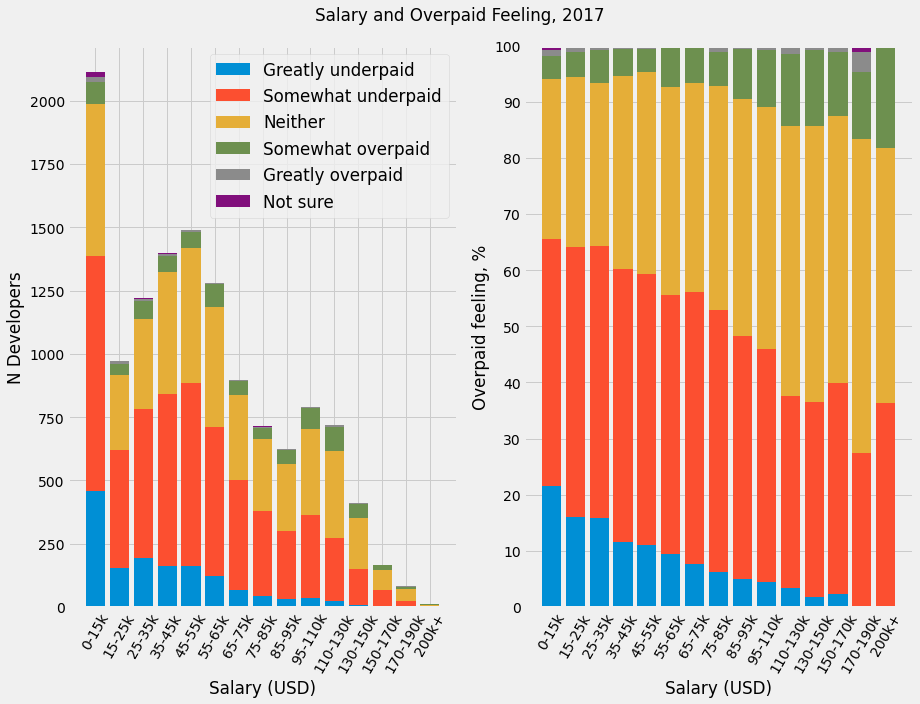

In [63]:
bottom = len(intervals) * [0]
ticks = np.arange(len(intervals))
labels = convert_xticks(intervals)

plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,10))
for overpaid in overpaid_dict:
    axes[0].bar(ticks, salary_overpaid_2017[overpaid], bottom=bottom)
    bottom += salary_overpaid_2017[overpaid]
    
axes[0].set_xlabel('Salary (USD)')
axes[0].set_ylabel('N Developers')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels, rotation=60)
axes[0].legend(labels=overpaid_dict.values(), fontsize='large', loc='upper right')

bottom = len(intervals) * [0]
for overpaid in overpaid_dict:
    row = salary_overpaid_2017[overpaid] * 100 / salary_overpaid_2017['Total']
    axes[1].bar(ticks, row, bottom=bottom)
    bottom += row

axes[1].set_xlabel('Salary (USD)')
axes[1].set_ylabel('Overpaid feeling, %')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels, rotation=60)
axes[1].set_yticks([i for i in range(0, 101, 10)])
axes[1].legend([]).set_visible(False)

fig.suptitle('Salary and Overpaid Feeling, 2017')

fig.tight_layout()
plt.show()

In [17]:
cumsum = salary_overpaid_2017.loc[:, 'Total, %'].cumsum()
cumsum.index = convert_xticks(salary_overpaid_2017.index)
cumsum

0-15k        16.383523
15-25k       23.915910
25-35k       33.372120
35-45k       44.209138
45-55k       55.767590
55-65k       65.704755
65-75k       72.655341
75-85k       78.194089
85-95k       83.050190
95-110k      89.186254
110-130k     94.779303
130-150k     97.959817
150-170k     99.263052
170-190k     99.914669
200k+       100.000000
Name: Total, %, dtype: float64

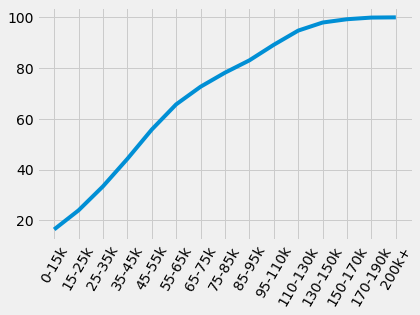

In [60]:
plt.plot(cumsum)
plt.xticks(labels, rotation=60)
plt.show()

Exploration of 2017 year data set gives us this info:
- Most programmers ~89% earn up to 110,000 USD. The biggest cluster is ~16% of all programmers have up to 15,000 USD salary. Salary that starts from 130,001 USD is rare that have less than 2% of developers.

It is not a secret that underpaid feeling is the greatest among developers with lower salaries. What is the most interesting is the curve of how this feeling is decreasing while salary is approaching the top values.
- Underpaid feeling break points (in USD) are:
    - 35,000
    - 55,000
    - 75,000 
    - 110,000

*Can see the steps on the percentage scale up to 35,000 USD included, from 35,001 USD to 55,000 USD included, from 55,001 USD to 75,000 USD included, then it's sliding down until next step at from 110,001 USD to 170,000 USD.*

- Overpaid feeling break points (in USD) are:
    - 55,000
    - 85,000
    - 110,000

## Exploring Language* by Job and Career Satisfaction

\**Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?*

#### Setup functions for cleaning datasets

In [18]:
def strlist_to_dummies(col, sep=";"):
    """Convert strings, containing separated values in pd.series to pd.dummies.
    
    Args:
      col (Pandas.Series): Column with lists, that will be separated and exploded.
      sep (str): Separator of the list values.
      
    Returns:
      Pandas.DataFrame dummies.
    """
    # Converting separated values from single string to list
    splitted = col.str.split(sep)
    # Removing unnecessary leading/trailing spaces and handling NAN cases
    stripped = splitted.apply(lambda x: [i.strip() for i in x] if type(x) is list else x)
    explode = stripped.explode()
    dummies = pd.get_dummies(explode)
    return dummies.sum(level=0)

def group_sat_lang(df, sat, lang, sat_sorted, sat_mapping=None):
    """Make dummies from lang column, select satisfaction and dissatisfaction columns,
    group by satisfaction
    
    Args:
      df (Pandas.DataFrame): Column with satisfaction values.
      sat (str): Name of the column with satisfaction values.
      lang (str): Name of the column with languages.
      sat_sorted (list): Names of the satisfaction columns in needed order.
      sat_mapping (dict): Dictionary to map satisfaction values.
      
    Returns:
      Pandas.DataFrame processed and groupped.
    """
    # Processing separated values in language column
    df_ = df.copy()
    df_ = df_.dropna(subset=[sat, lang], axis=0)
    if sat_mapping:
        df_[sat] = df_[sat].map(sat_mapping)
    dummies = strlist_to_dummies(df_[lang])
    # Selecting satisfaction and dissatisfaction columns
    df_ = pd.concat([df_[sat], dummies], axis=1)
    median = len(sat_sorted) // 2
    sat_select = sat_sorted[-median:] if "dissatisfied" in sat_sorted[0] else sat_sorted[:median]
    dis_select = sat_sorted[:median] if "dissatisfied" in sat_sorted[0] else sat_sorted[-median:]
    # Grouping columns, summing values
    groupped = df_.groupby(by=sat).sum().T
    groupped = groupped[sat_sorted]
    groupped['Total'] = groupped.sum(axis=1)
    groupped['Satisfaction'] = groupped[sat_select].sum(axis=1) / groupped['Total']
    groupped['Dissatisfaction'] = groupped[dis_select].sum(axis=1) / groupped['Total']
    groupped['Sat_Net'] = groupped['Satisfaction'] - groupped['Dissatisfaction']
    return groupped

#### Setup functions for barh plot

In [19]:
def calc_abs_scale(arr):
    maximum = int(np.max(arr))
    rank = pow(10, int(math.log10(maximum)))
    # Rounding integer to the next rank
    maximum_adj = int(np.ceil(maximum/rank)*rank)
    max_steps = 10
    step = int(maximum_adj/max_steps)
    scale = {}
    for i in range(0, maximum+step+1, step):
        scale[str(i)] = i
    return scale

def calc_pct_scale(step=10):
    scale = {}
    for i in range(0, 101, step):
        scale[str(i)] = i
    # Checking that 100% is included
    last_num = list(scale.values())[-1]
    if last_num != 100:
        scale[str(100)] = 100
    return scale

def plot_satisfaction_barh(df, sat, year, sat_sorted, style='fivethirtyeight'):
    """Plot language recently worked with by satisfaction (job/career) barh.
    
    Args:
      df (pandas.DataFrame): Dataset.
      sat (str): 'Job'/'Career' for the title.
      year (al/num): Year of the dataset for the title.
      sat_sorted (list): Names of the satisfaction columns in needed order.
      style (str): Plt style.
    
    Returns: Nothing.
    """
    plt.style.use(style)

    fig = plt.figure(figsize=(13, 10))

    gs = fig.add_gridspec(1,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    lang_sat = df.copy()
    lang_sat = lang_sat.sort_values(by='Total', ascending=False)

    left = lang_sat.shape[0] * [0]
    for column in sat_sorted:
        ax1.barh(lang_sat.index.tolist(), lang_sat[column], left=left)
        left += lang_sat[column]

    ax1.set_xlabel('N Developers')
    ax1.set_ylabel('Language Recently Worked With')
    scale = calc_abs_scale(lang_sat['Total'])
    ax1.set_xticks(list(scale.values()))
    ax1.set_xticklabels(list(scale.keys()))
    ax1.tick_params(axis='x', labelrotation=45)
    labels = ['Neither' if 'Neither' in i else i for i in sat_sorted]
    ax1.legend(labels=labels, fontsize='large', loc='upper right')
    
    lang_sat_pct = df.copy()
    lang_sat_pct = lang_sat_pct.sort_values(by='Sat_Net', ascending=False)

    left = lang_sat_pct.shape[0] * [0]
    for column in sat_sorted:
        row = lang_sat_pct[column] * 100 / lang_sat_pct['Total']
        ax2.barh(lang_sat_pct.index.tolist(), row, left=left)
        left += row

    ax2.set_xlabel(f'{sat} Satisfaction, %')
    ax2.set_ylabel('Language Recently Worked With')
    scale_pct = calc_pct_scale()
    ax2.set_xticks(list(scale_pct.values()))
    ax2.set_xticklabels(list(scale_pct.keys()))
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.legend([]).set_visible(False)

    fig.suptitle(f'{sat} Satisfaction and Language Recently Worked With, {year}')
    fig.tight_layout()
    plt.show()

#### Setup functions for scatter plots

In [20]:
def get_markers():
    return ['s', 'D', 'p', 'o', 'X', '+', 'v', '^', '<', '>', '.', ',']

def get_line_best_fit(x, y):
    line = np.linspace(0, 100, num=101, endpoint=True)
    m, b = np.polyfit(x, y, 1)
    return line * m + b, m, b

def calc_scatter_lims(x, y, padding=2):
    lim_min_raw = min(x.min(), y.min())
    lim_min = math.floor(lim_min_raw - padding)
    lim_max_raw = max(x.max(), y.max())
    lim_max = math.ceil(lim_max_raw + padding)
    return lim_min, lim_max

def plot_satisfaction_scatter(df_x, df_y, xlabel, ylabel, title):
    markers = get_markers()
    size_coef = lambda x: (df_x.loc[x, 'Total'] + df_y.loc[x, 'Total']) / \
                            (df_x.loc[:, 'Total'].max() + df_y.loc[:, 'Total'].max())
    
    languages = df_x.index
    plt.figure(figsize=(10, 10))
    for lang, marker in zip(languages, markers):
        x = df_x.loc[lang, 'Satisfaction'] * 100
        y = df_y.loc[lang, 'Satisfaction'] * 100
        plt.scatter(x, y, marker=marker, alpha=0.8, s=1000*size_coef(lang))
    
    min_lim, max_lim = calc_scatter_lims(df_x.loc[:, 'Satisfaction'] * 100, df_y.loc[:, 'Satisfaction'] * 100, 3)
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(languages, fontsize='large', loc='lower right')
    plt.title(title)
    line, m, b = get_line_best_fit(df_x.loc[:, 'Satisfaction'] * 100, df_y.loc[:, 'Satisfaction'] * 100)
    plt.plot(line, c='gray', alpha=0.2)
    plt.annotate(f'Regression line coefficient is {m:.2f}', xy=(min_lim, min_lim), c='gray')
    plt.show()

In [21]:
def plot_tot_to_netsat_scatter(df, xlabel, ylabel, title):
    maximum = df['Total'].max()
    markers = get_markers()
    size_coef = lambda x: df.loc[x, 'Total'] / maximum
    
    languages = df.index.tolist()
    plt.figure(figsize=(10, 10))
    for lang, marker in zip(languages, markers):
        x = df.loc[lang, 'Total'] * 100 / maximum
        y = df.loc[lang, 'Sat_Net'] * 100
        plt.scatter(x, y, marker=marker, s=1000*size_coef(lang))
    
    min_lim, max_lim = calc_scatter_lims(df.loc[:, 'Total'] * 100 / maximum, df.loc[:, 'Sat_Net'] * 100, 3)
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.legend(languages, fontsize='large', loc='lower right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    line, m, b = get_line_best_fit(df.loc[:, 'Total'] * 100 / maximum, df.loc[:, 'Sat_Net'] * 100)
    plt.plot(line, c='gray', alpha=0.2)
    plt.annotate(f'Regression line coefficient is {m:.2f}', xy=(min_lim, min_lim), c='gray')
    plt.show()

In [22]:
def plot_tot_to_netsat_scatter_split(df, threshold, xlabel, ylabel, title):
    maximum = df['Total'].max()
    languages = df.index.tolist()
    plt.figure(figsize=(10, 10))
    x = df.loc[:, 'Total'] * 100 / maximum
    y = df.loc[:, 'Sat_Net'] * 100
    x_left = x[x <= threshold]
    y_left = y[x_left.index]
    x_right = x[x > threshold]
    y_right = y[x_right.index]
    plt.scatter(x_left, y_left)
    plt.scatter(x_right, y_right)
    
    min_lim, max_lim = calc_scatter_lims(x, y, 3)
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.legend([]).set_visible(False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    line, m, b = get_line_best_fit(x_left, y_left)
    plt.plot(line, c='blue', alpha=0.3)
    plt.annotate(f'Regression line coefficient of languages up to {threshold}% popularity is {m:.2f}', xy=(min_lim+3, min_lim+5), c='blue')
    line, m, b = get_line_best_fit(x, y)
    plt.plot(line, c='gray', alpha=0.1)
    plt.annotate(f'Regression line coefficient of all languages is {m:.2f}', xy=(min_lim+3, min_lim+3), c='gray')
    plt.show()
    print(f'corrcoef (blue): {np.corrcoef(x_left, y_left)[0][1]:.3f}\ncorrcoef (red): {np.corrcoef(x_right, y_right)[0][1]:.3f}\ncorrcoef (total): {np.corrcoef(x, y)[0][1]:.3f}')

In [23]:
survey_2018 = pd.read_csv(surveys['2018']['data'], low_memory=False)
# print(survey_2018.shape, survey_2018.columns.tolist())

In [24]:
survey_2019 = pd.read_csv(surveys['2019']['data'], low_memory=False)
# print(survey_2019.shape, survey_2019.columns.tolist())

In [25]:
survey_2020 = pd.read_csv(surveys['2020']['data'], low_memory=False)
# print(survey_2020.shape, survey_2020.columns.tolist())

### Exploring 2017 year survey data

#### Analyzing Language by Job and Career Satisfaction

Looking at the absolute values bar charts we can clearly see that:
- The most used language in 2017 is JavaScript.
- The most satisfying language in 2017 is JavaScript.

But it's hard to compare satisfaction of the languages on the absolute values scale. For the best comparison will use percentage scale: every language's satisfaction category will be divided by it's own total.
On the percentage scale charts languages are sorted by net total satisfaction\* ascending.

Looking at the percentage values bar charts we can clearly see that:


\**Satisfaction = (Extremely satisfied + Moderately satisfied + Slightly satisfied) - (Slightly dissatisfied, Moderately dissatisfied, Extremely dissatisfied)*

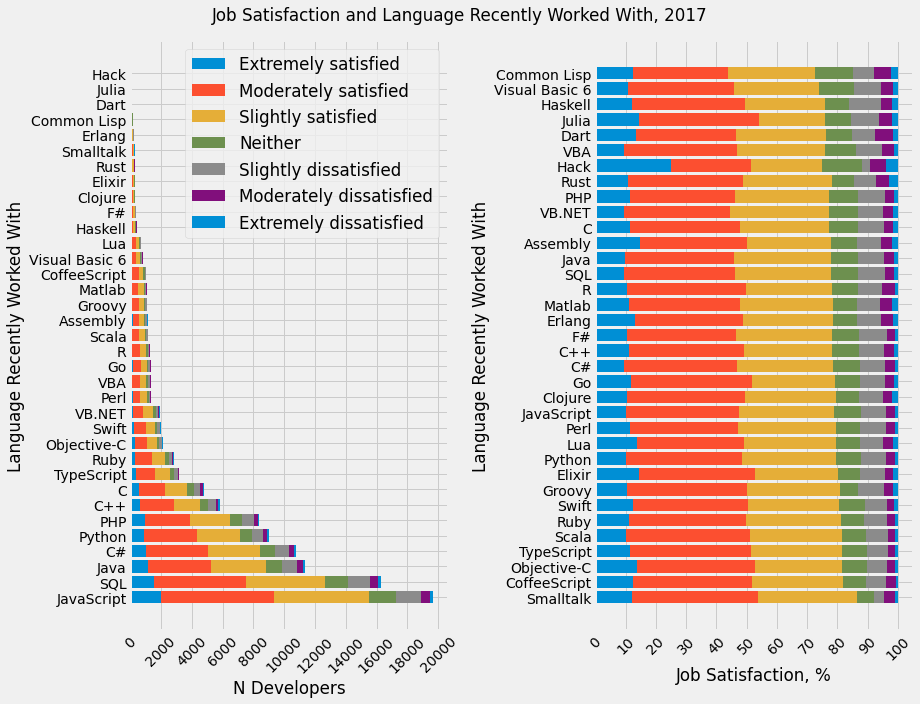

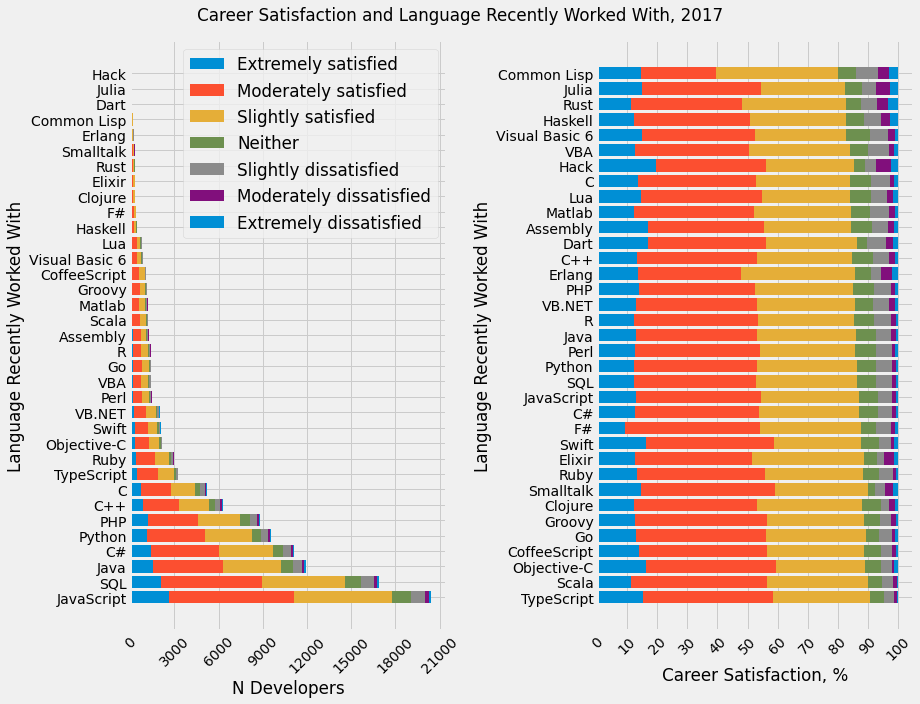

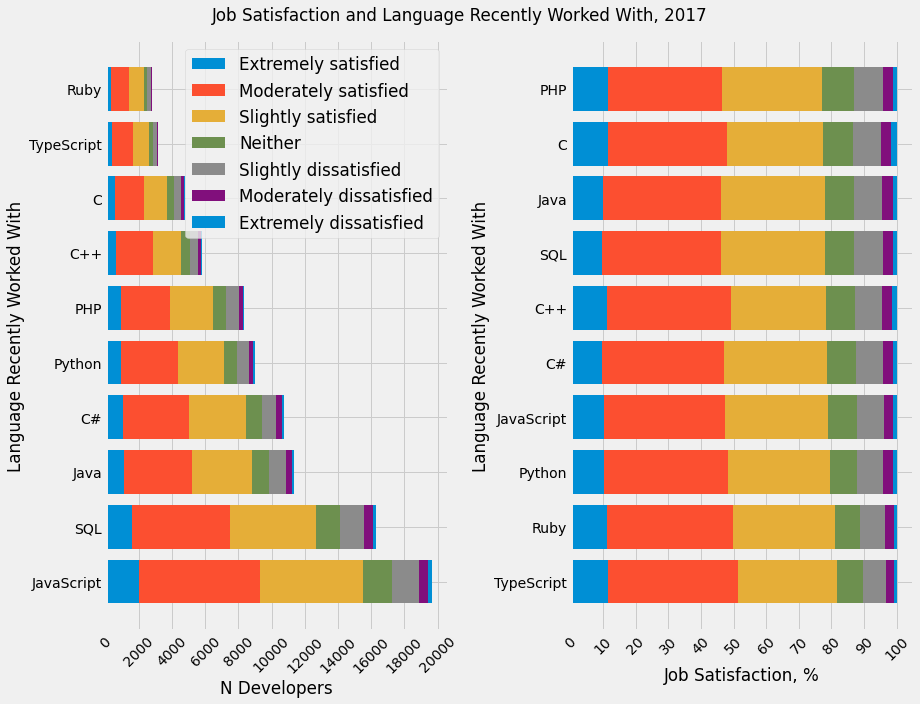

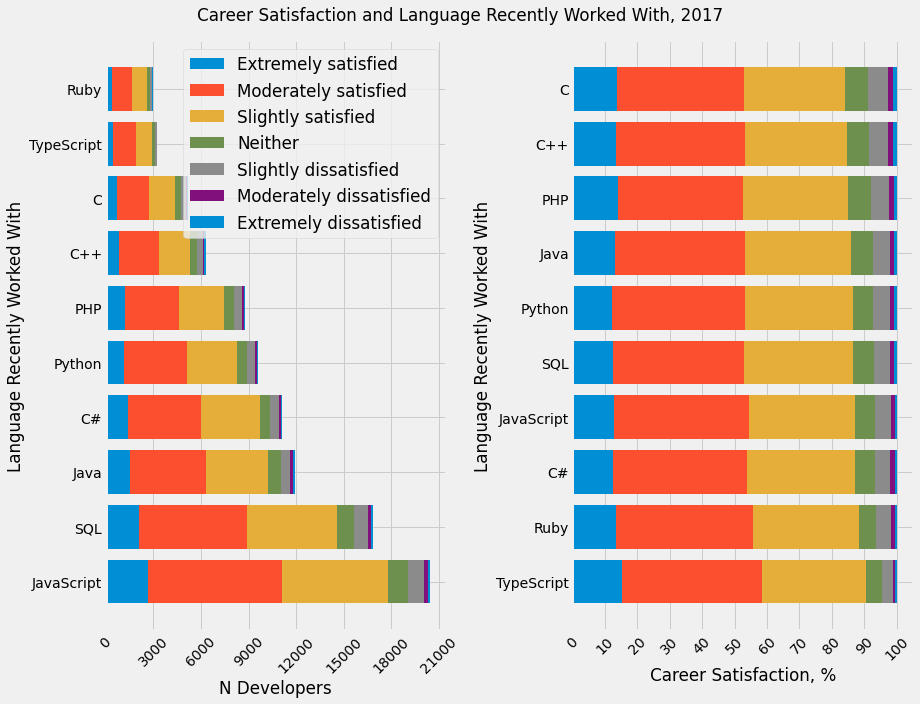

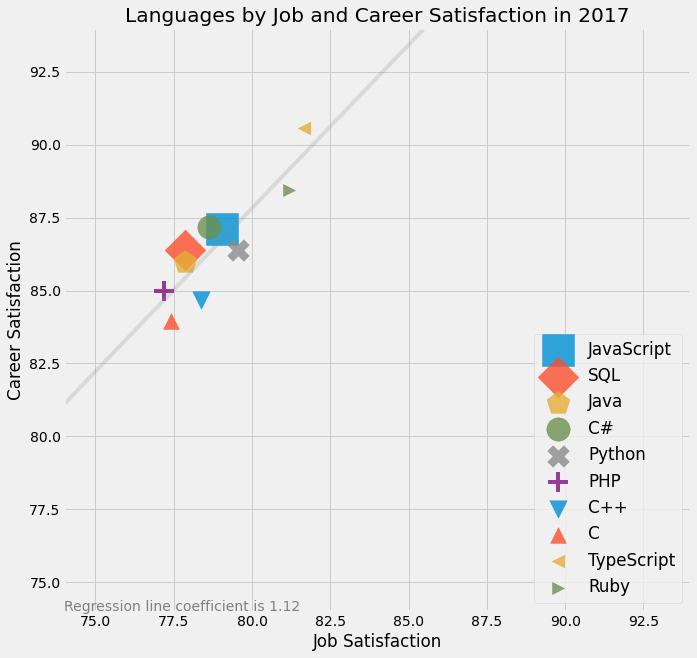

In [26]:
mapping_2017 = {
    10: 'Extremely satisfied',
    9: 'Moderately satisfied',
    8: 'Moderately satisfied',
    7: 'Slightly satisfied',
    6: 'Slightly satisfied',
    5: 'Neither satisfied nor dissatisfied',
    4: 'Slightly dissatisfied',
    3: 'Slightly dissatisfied',
    2: 'Moderately dissatisfied',
    1: 'Moderately dissatisfied',
    0: 'Extremely dissatisfied'
}

columns_sorted_2017 = [
    'Extremely satisfied',
    'Moderately satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Moderately dissatisfied',
    'Extremely dissatisfied',
]

language_job_satisfaction_2017 = group_sat_lang(survey_2017, 'JobSatisfaction', 'HaveWorkedLanguage', columns_sorted_2017, mapping_2017)
language_career_satisfaction_2017 = group_sat_lang(survey_2017, 'CareerSatisfaction', 'HaveWorkedLanguage', columns_sorted_2017, mapping_2017)

plot_satisfaction_barh(language_job_satisfaction_2017, 'Job', '2017', columns_sorted_2017)
plot_satisfaction_barh(language_career_satisfaction_2017, 'Career', '2017', columns_sorted_2017)


"""
Exploring top 10 most used languages in 2017
"""
# Languages by job satisfaction
ljs_2017_total_top_10 = language_job_satisfaction_2017.loc[language_job_satisfaction_2017['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2017_total_top_10, 'Job', '2017', columns_sorted_2017)

# Languages by career satisfaction
lcs_2017_total_top_10 = language_career_satisfaction_2017.loc[language_career_satisfaction_2017['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2017_total_top_10, 'Career', '2017', columns_sorted_2017)

plot_satisfaction_scatter(ljs_2017_total_top_10, lcs_2017_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2017')

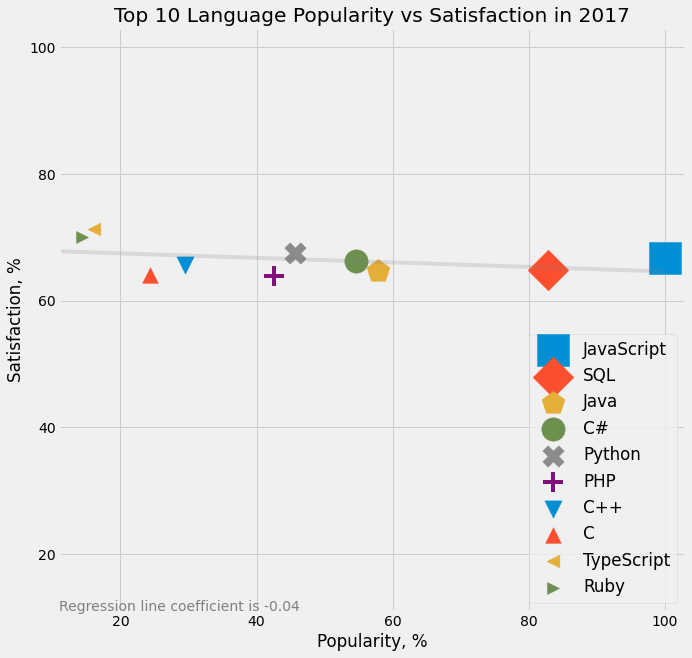

In [27]:
plot_tot_to_netsat_scatter(ljs_2017_total_top_10, 'Popularity, %', 'Satisfaction, %', 'Top 10 Language Popularity vs Satisfaction in 2017')

There might be a correlation between the popularity of the language (number of developers who worked with it) and it's satisfaction. Need to investigate this hypothesis further with the whole language list.

In [28]:
language_job_satisfaction_2017.sort_values(by='Sat_Net', ascending=False)

JobSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
Smalltalk,34.0,117.0,92.0,16.0,9.0,10.0,3.0,281.0,0.864769,0.078292,0.786477
CoffeeScript,129.0,412.0,316.0,78.0,70.0,34.0,6.0,1045.0,0.820096,0.105263,0.714833
Objective-C,293.0,823.0,606.0,170.0,143.0,51.0,22.0,2108.0,0.816888,0.102467,0.714421
TypeScript,364.0,1269.0,962.0,255.0,226.0,77.0,25.0,3178.0,0.816551,0.103210,0.713342
Scala,117.0,480.0,353.0,94.0,83.0,26.0,12.0,1165.0,0.815451,0.103863,0.711588
Ruby,319.0,1086.0,886.0,217.0,214.0,73.0,27.0,2822.0,0.811836,0.111269,0.700567
Swift,248.0,751.0,593.0,168.0,143.0,45.0,27.0,1975.0,0.806076,0.108861,0.697215
Groovy,117.0,438.0,344.0,65.0,96.0,34.0,16.0,1110.0,0.809910,0.131532,0.678378
Elixir,48.0,126.0,90.0,24.0,27.0,9.0,5.0,329.0,0.802432,0.124620,0.677812
Python,918.0,3425.0,2801.0,756.0,714.0,268.0,97.0,8979.0,0.795634,0.120169,0.675465


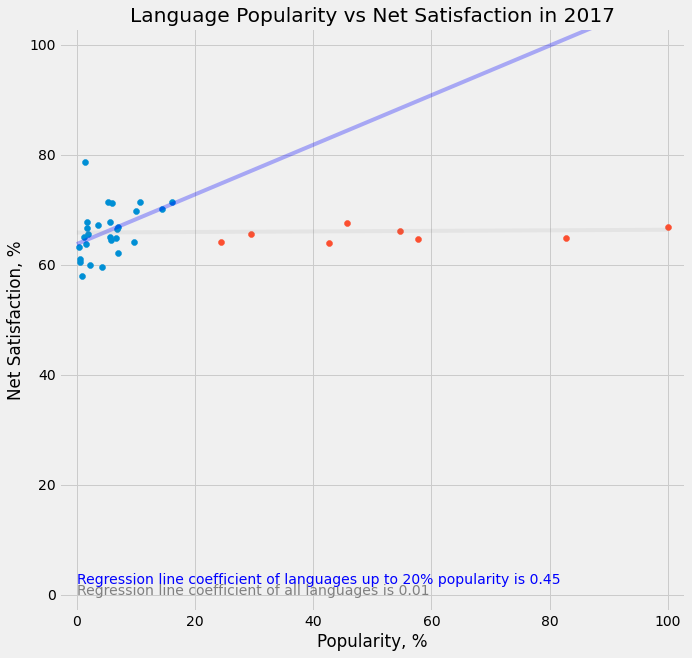

corrcoef (blue): 0.415
corrcoef (red): 0.319
corrcoef (total): 0.030


In [29]:
plot_tot_to_netsat_scatter_split(language_job_satisfaction_2017, 20, 'Popularity, %', 'Net Satisfaction, %', 'Language Popularity vs Net Satisfaction in 2017')

Looks like there is a correlation in unpopular languages vs satisfaction but it's weak with p-value of ~0.42. Regression line coefficient of 0.45 tells that it's a positive correlation. And the more popular language becomes the less satisfaction programmers get from it.

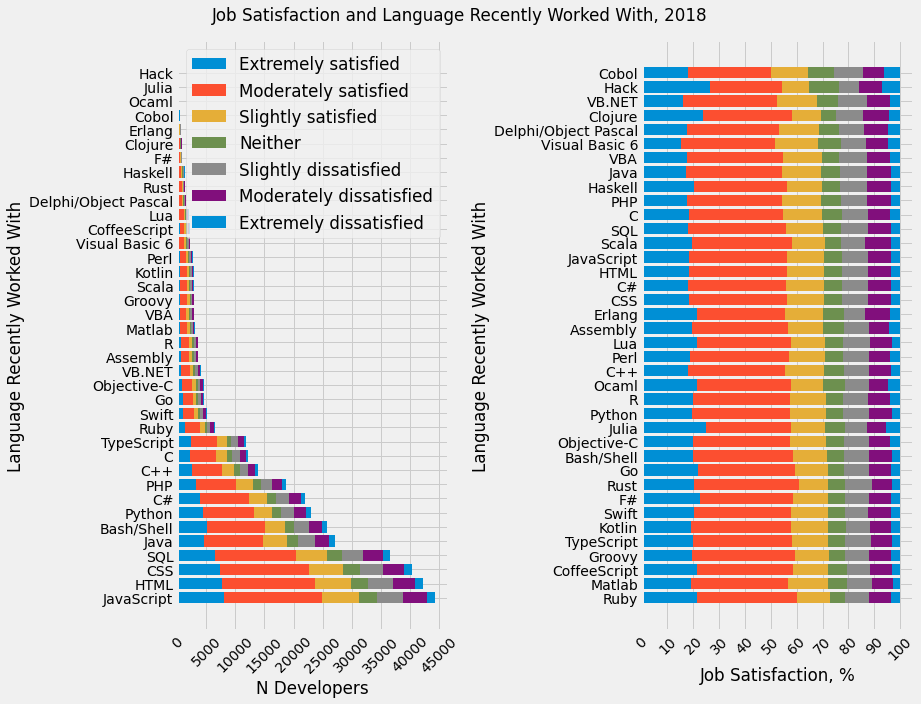

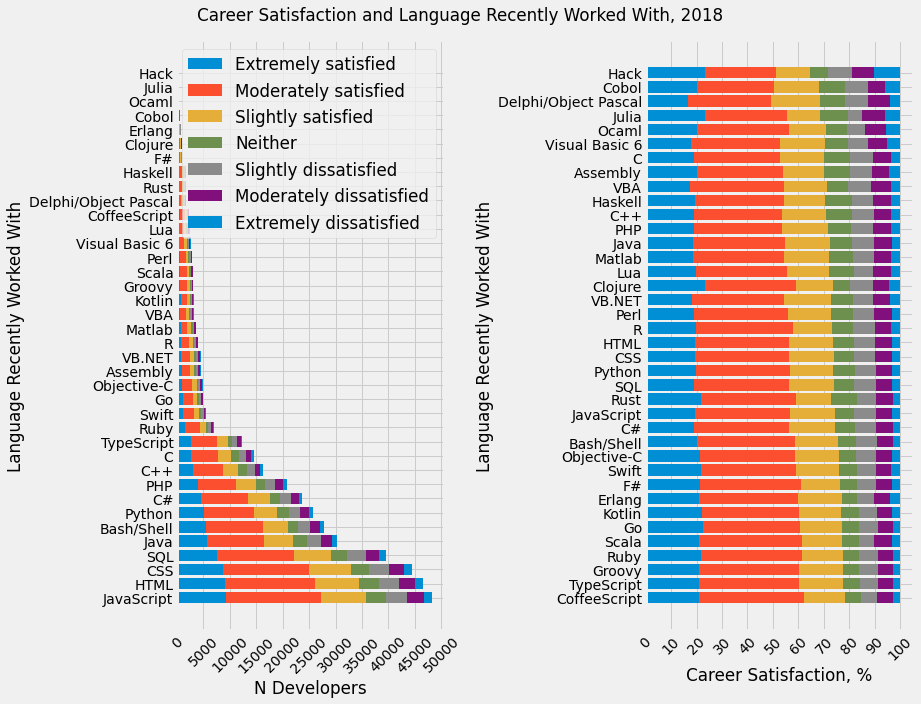

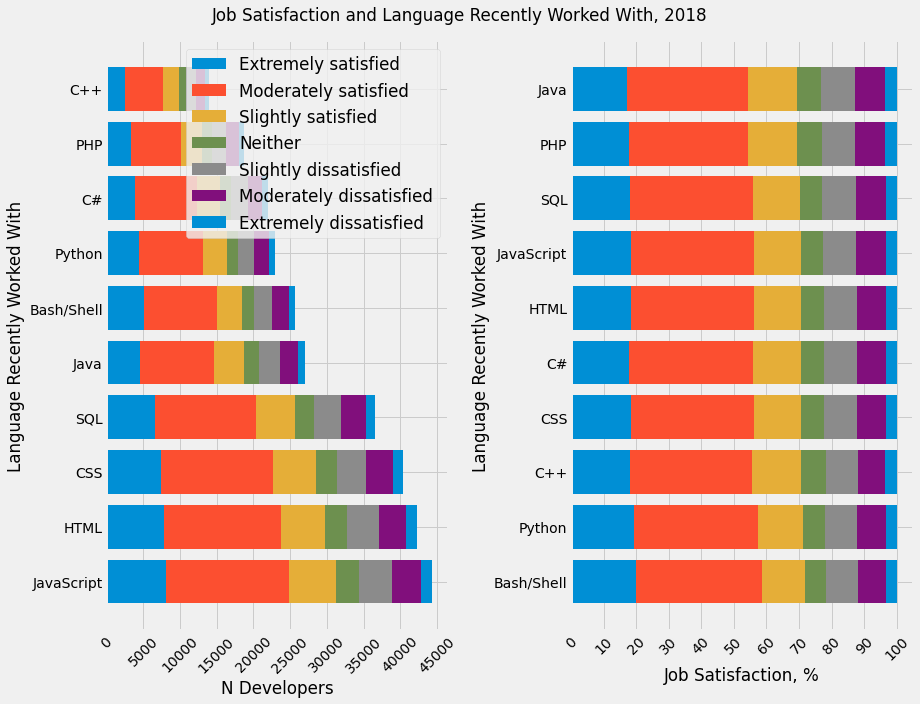

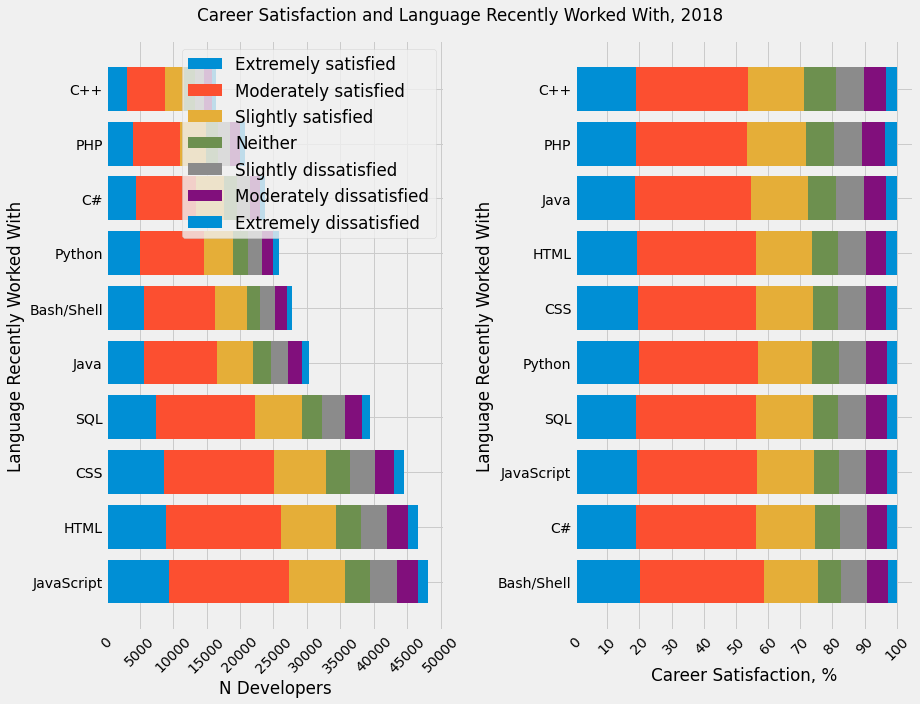

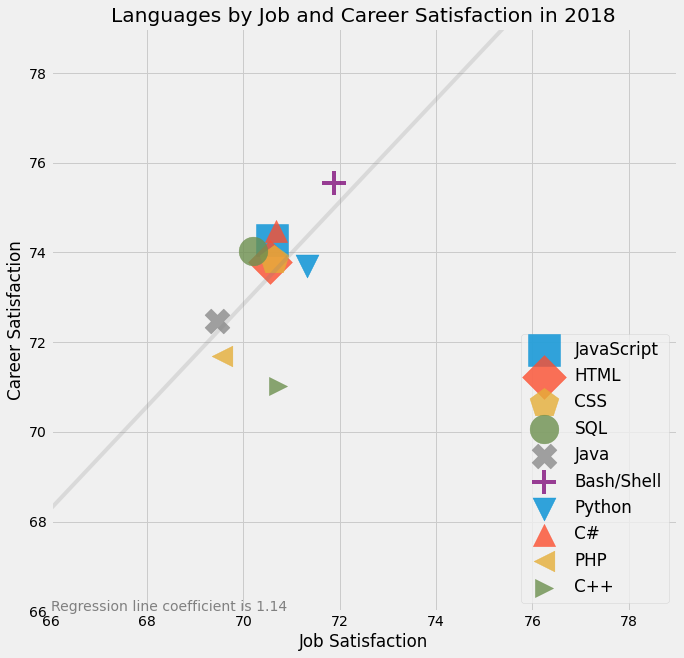

In [30]:
columns_sorted_2018 = [
    'Extremely satisfied',
    'Moderately satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Moderately dissatisfied',
    'Extremely dissatisfied',
]

language_job_satisfaction_2018 = group_sat_lang(survey_2018, 'JobSatisfaction', 'LanguageWorkedWith', columns_sorted_2018)
language_career_satisfaction_2018 = group_sat_lang(survey_2018, 'CareerSatisfaction', 'LanguageWorkedWith', columns_sorted_2018)

plot_satisfaction_barh(language_job_satisfaction_2018, 'Job', '2018', columns_sorted_2018)
plot_satisfaction_barh(language_career_satisfaction_2018, 'Career', '2018', columns_sorted_2018)


"""
Exploring top 10 most used languages in 2018
"""
# Languages by job satisfaction
ljs_2018_total_top_10 = language_job_satisfaction_2018.loc[language_job_satisfaction_2018['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2018_total_top_10, 'Job', '2018', columns_sorted_2018)

# Languages by career satisfaction
lcs_2018_total_top_10 = language_career_satisfaction_2018.loc[language_career_satisfaction_2018['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2018_total_top_10, 'Career', '2018', columns_sorted_2018)

assert len(set(ljs_2018_total_top_10.index.tolist()).difference(lcs_2018_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2018_total_top_10, lcs_2018_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2018')

In [31]:
language_job_satisfaction_2018

JobSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
Assembly,726.0,1360.0,509.0,296.0,350.0,297.0,152.0,3690.0,0.703252,0.216531,0.486721
Bash/Shell,5130.0,9896.0,3430.0,1628.0,2514.0,2259.0,819.0,25676.0,0.718804,0.217791,0.501013
C,2231.0,4467.0,1831.0,972.0,1227.0,1052.0,452.0,12232.0,0.697269,0.223267,0.474003
C#,3915.0,8367.0,3222.0,1522.0,2225.0,1956.0,729.0,21936.0,0.706783,0.223833,0.482950
C++,2520.0,5206.0,2107.0,1034.0,1376.0,1163.0,497.0,13903.0,0.707257,0.218370,0.488887
CSS,7446.0,15199.0,5859.0,2855.0,4027.0,3621.0,1341.0,40348.0,0.706454,0.222787,0.483667
Clojure,202.0,292.0,94.0,51.0,87.0,85.0,37.0,848.0,0.693396,0.246462,0.446934
Cobol,79.0,141.0,64.0,44.0,49.0,36.0,28.0,441.0,0.643991,0.256236,0.387755
CoffeeScript,466.0,808.0,292.0,159.0,198.0,182.0,70.0,2175.0,0.720000,0.206897,0.513103
Delphi/Object Pascal,283.0,567.0,242.0,128.0,154.0,144.0,77.0,1595.0,0.684639,0.235110,0.449530


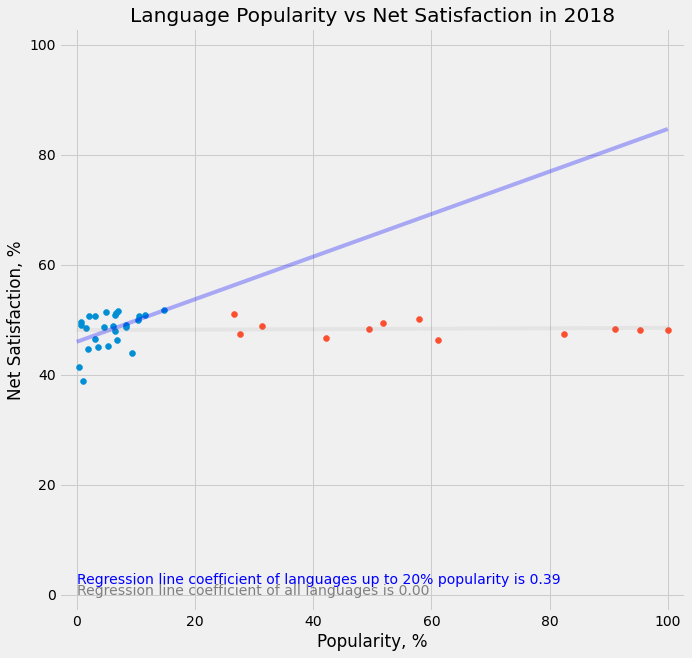

corrcoef (blue): 0.440
corrcoef (red): -0.231
corrcoef (total): 0.043


In [32]:
plot_tot_to_netsat_scatter_split(language_job_satisfaction_2018, 20, 'Popularity, %', 'Net Satisfaction, %', 'Language Popularity vs Net Satisfaction in 2018')

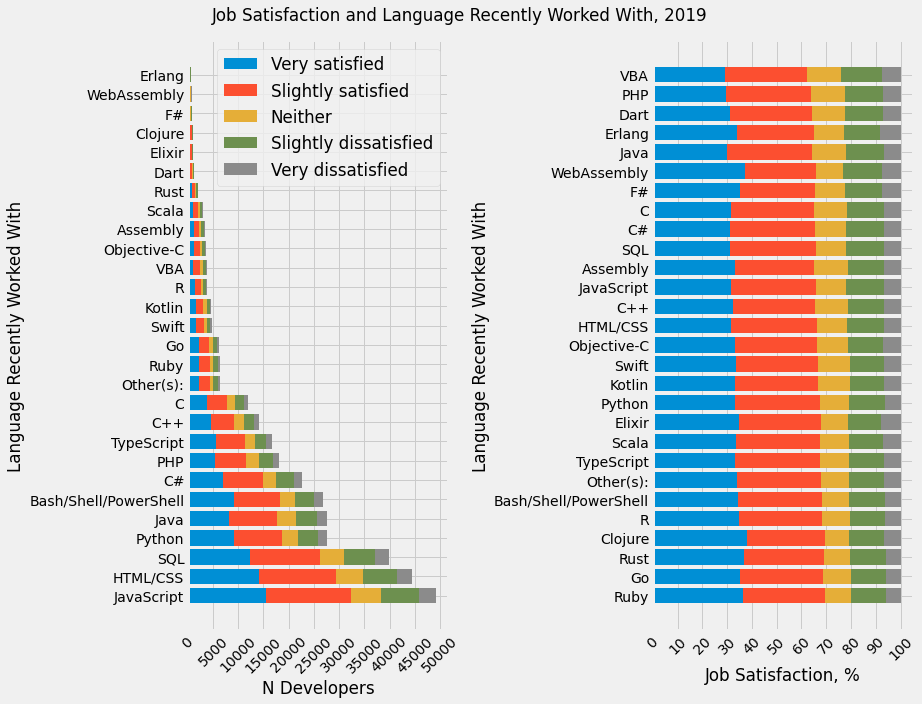

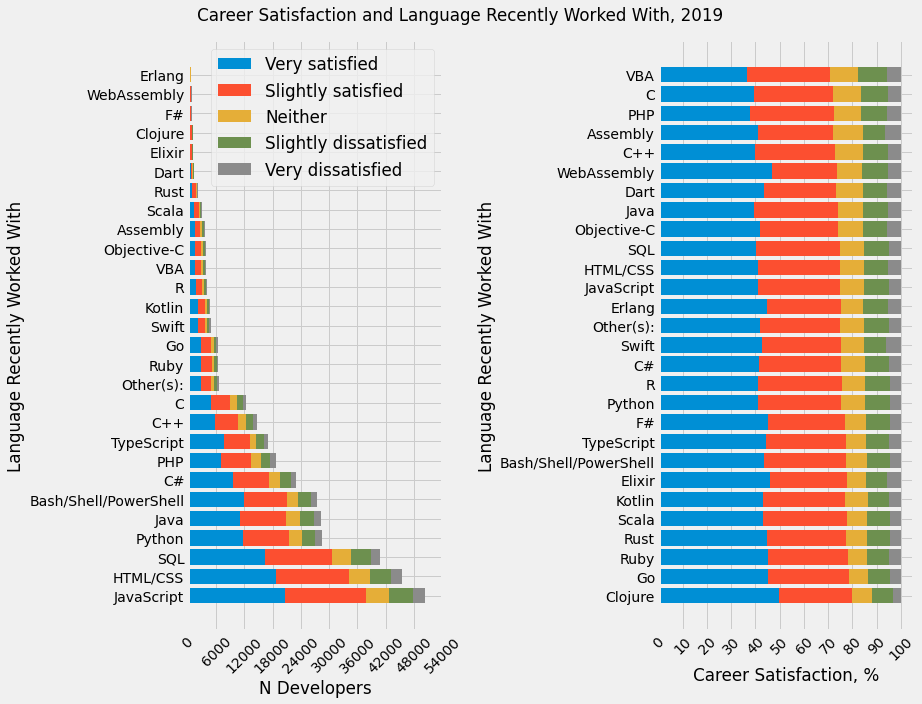

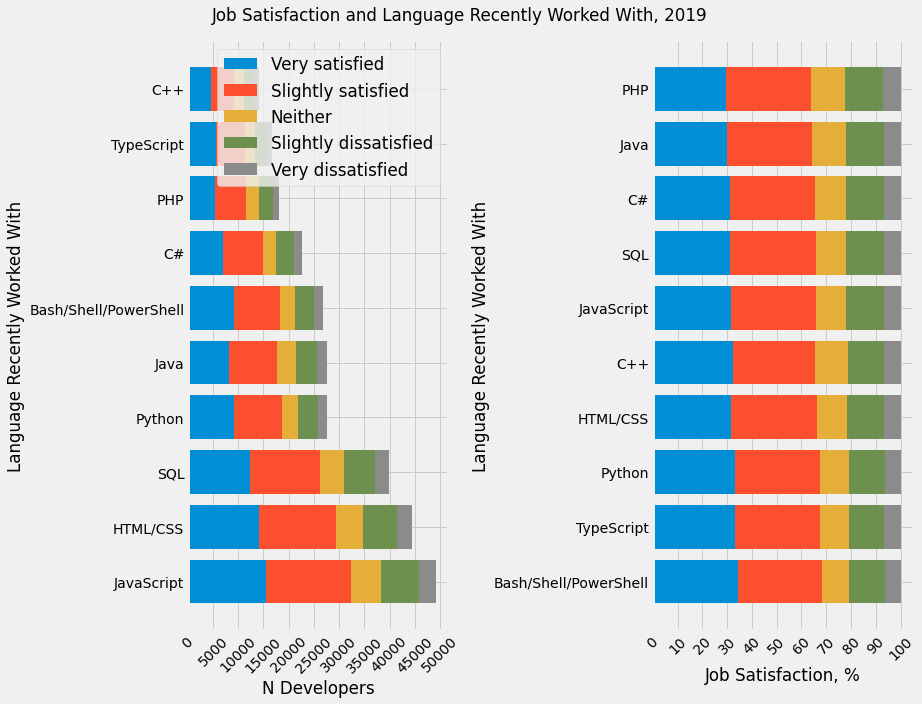

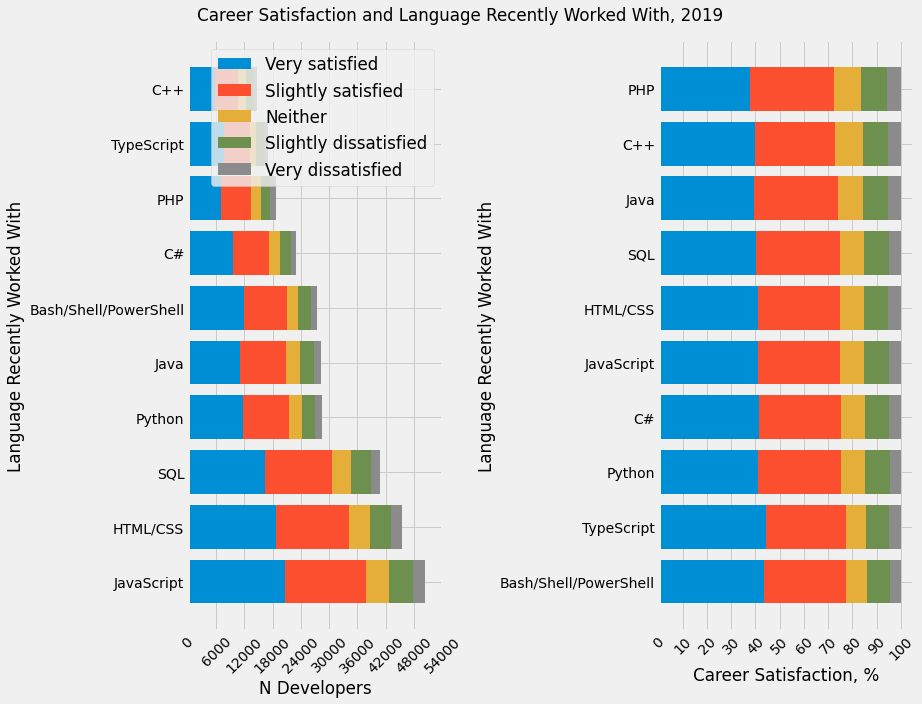

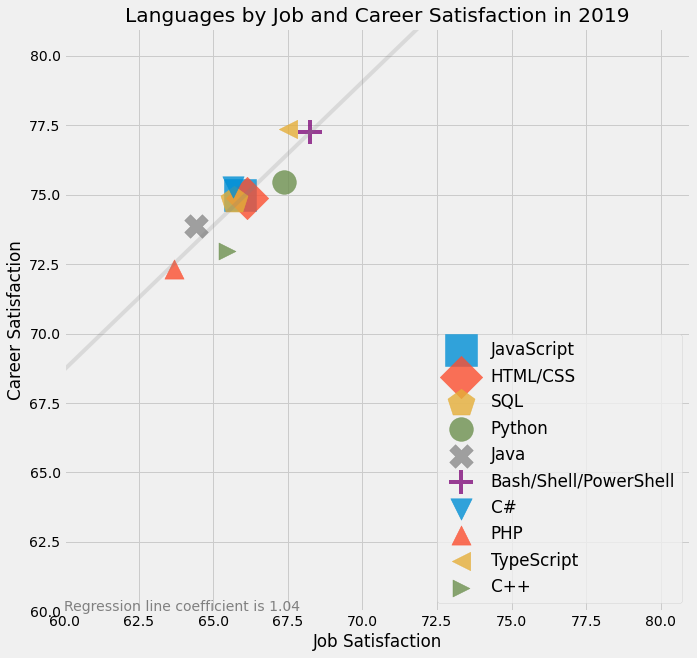

In [33]:
columns_sorted_2019 = [
    'Very satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Very dissatisfied',
]

language_job_satisfaction_2019 = group_sat_lang(survey_2019, 'JobSat', 'LanguageWorkedWith', columns_sorted_2019)
language_career_satisfaction_2019 = group_sat_lang(survey_2019, 'CareerSat', 'LanguageWorkedWith', columns_sorted_2019)

plot_satisfaction_barh(language_job_satisfaction_2019, 'Job', '2019', columns_sorted_2019)
plot_satisfaction_barh(language_career_satisfaction_2019, 'Career', '2019', columns_sorted_2019)


"""
Exploring top 10 most used languages in 2019
"""
# Languages by job satisfaction
ljs_2019_total_top_10 = language_job_satisfaction_2019.loc[language_job_satisfaction_2019['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2019_total_top_10, 'Job', '2019', columns_sorted_2019)

# Languages by career satisfaction
lcs_2019_total_top_10 = language_career_satisfaction_2019.loc[language_career_satisfaction_2019['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(lcs_2019_total_top_10, 'Career', '2019', columns_sorted_2019)

assert len(set(ljs_2019_total_top_10.index.tolist()).difference(lcs_2019_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2019_total_top_10, lcs_2019_total_top_10, 
                          'Job Satisfaction', 'Career Satisfaction', 
                          'Languages by Job and Career Satisfaction in 2019')

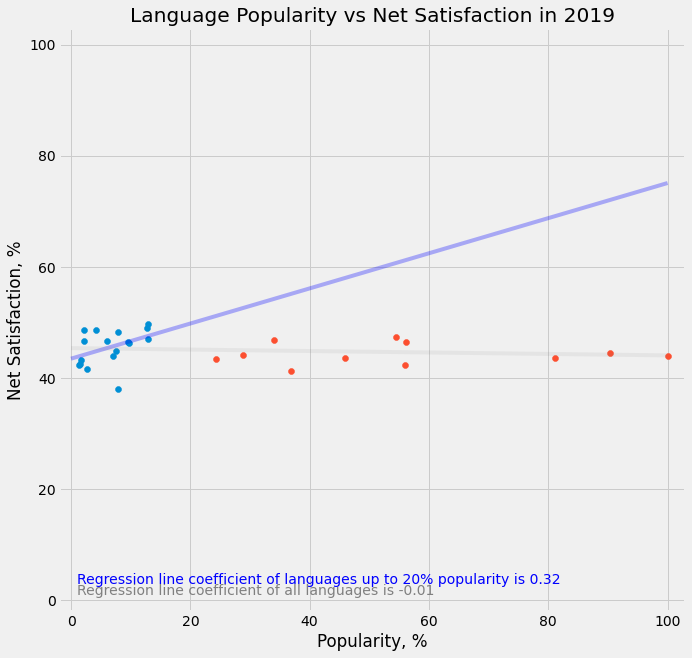

corrcoef (blue): 0.414
corrcoef (red): 0.023
corrcoef (total): -0.137


In [34]:
plot_tot_to_netsat_scatter_split(language_job_satisfaction_2019, 20, 'Popularity, %', 'Net Satisfaction, %', 'Language Popularity vs Net Satisfaction in 2019')

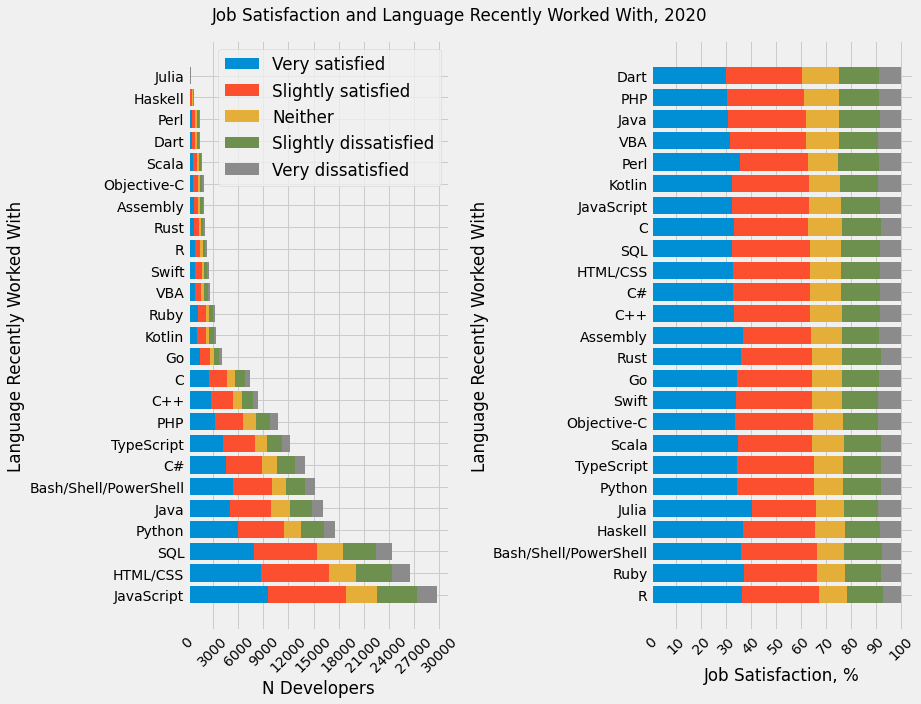

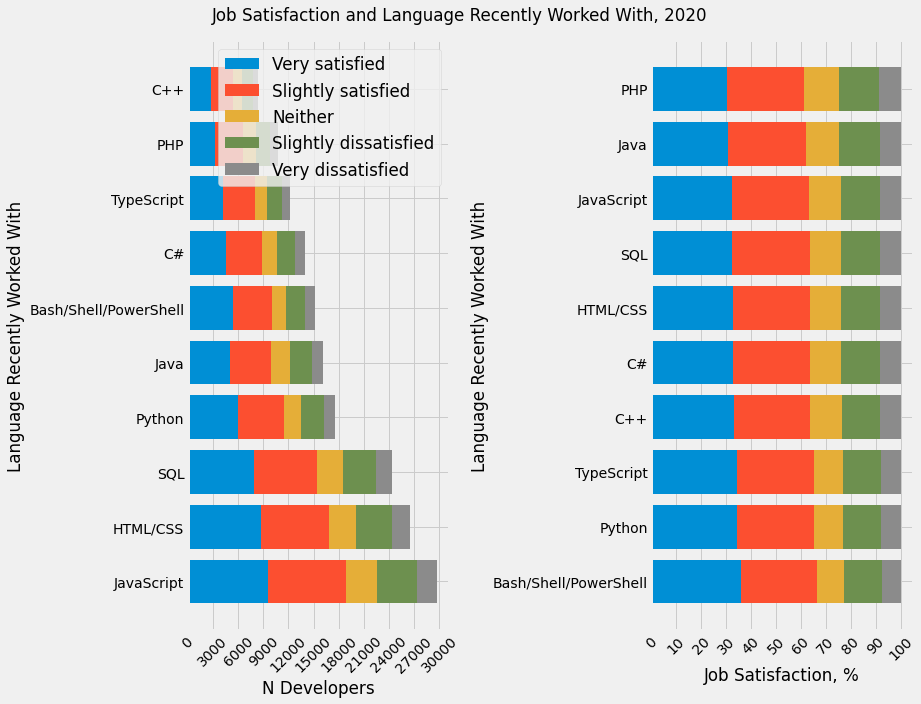

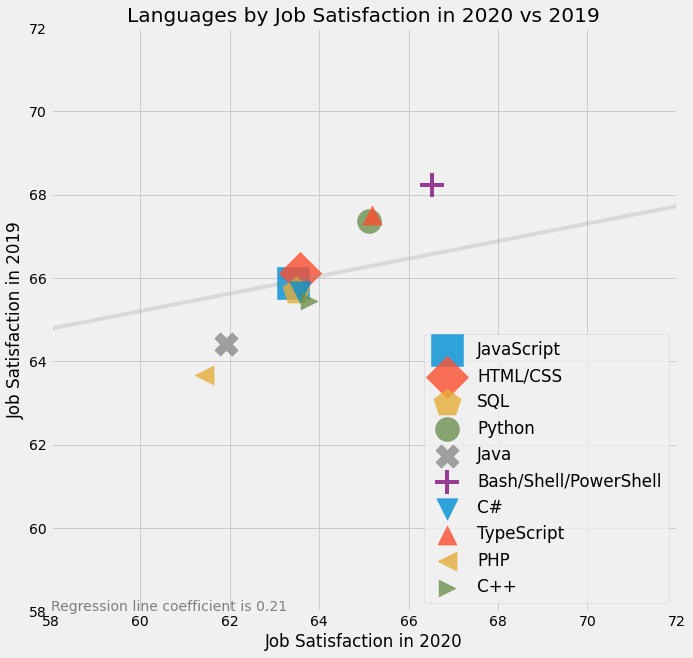

In [35]:
columns_sorted_2020 = [
    'Very satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Very dissatisfied',
]

language_job_satisfaction_2020 = group_sat_lang(survey_2020, 'JobSat', 'LanguageWorkedWith', columns_sorted_2020)

plot_satisfaction_barh(language_job_satisfaction_2020, 'Job', '2020', columns_sorted_2020)


"""
Exploring top 10 most used languages in 2020
"""
# Languages by job satisfaction
ljs_2020_total_top_10 = language_job_satisfaction_2020.loc[language_job_satisfaction_2020['Total'].sort_values(ascending=False)[:10].index]
plot_satisfaction_barh(ljs_2020_total_top_10, 'Job', '2020', columns_sorted_2020)

# There is no career satisfaction column in 2020 survey
# Plotting Job Satisfaction in 2020 vs Job Satisfaction in 2019
assert len(set(ljs_2020_total_top_10.index.tolist()).difference(ljs_2019_total_top_10.index.tolist())) == 0
plot_satisfaction_scatter(ljs_2020_total_top_10, ljs_2019_total_top_10, 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2019', 
                          'Languages by Job Satisfaction in 2020 vs 2019')


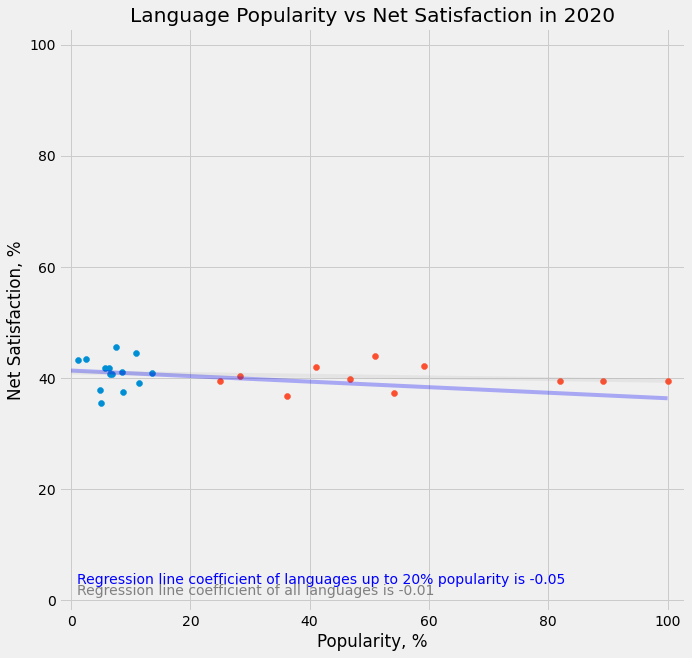

corrcoef (blue): -0.061
corrcoef (red): -0.041
corrcoef (total): -0.176


In [36]:
plot_tot_to_netsat_scatter_split(language_job_satisfaction_2020, 20, 'Popularity, %', 'Net Satisfaction, %', 'Language Popularity vs Net Satisfaction in 2020')

In [37]:
for idx, ljs in enumerate([ljs_2017_total_top_10, ljs_2018_total_top_10, ljs_2019_total_top_10]):
    difference = set(ljs_2020_total_top_10.index.tolist()).difference(ljs.index.tolist())
    print(f'Year: {idx+2017}, difference: {difference}')

Year: 2017, difference: {'HTML/CSS', 'Bash/Shell/PowerShell'}
Year: 2018, difference: {'HTML/CSS', 'Bash/Shell/PowerShell', 'TypeScript'}
Year: 2019, difference: set()


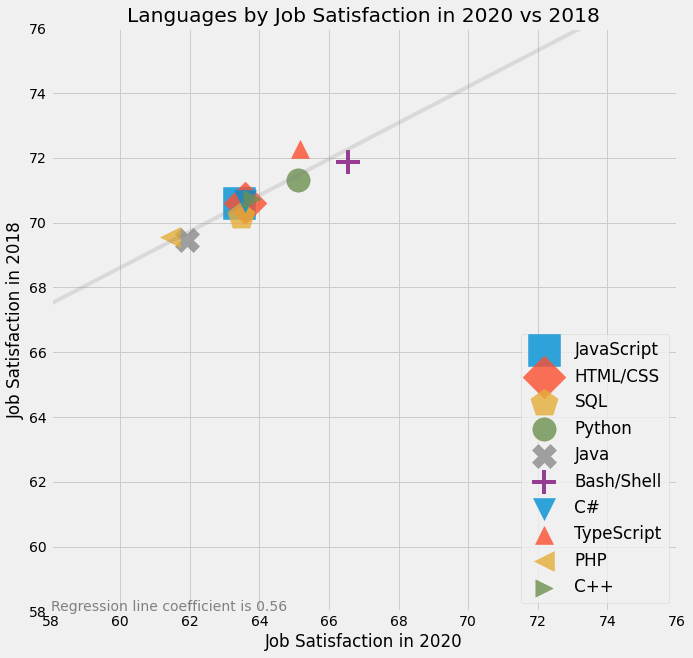

In [38]:
ljs_2020_total_top_10_for_2018 = ljs_2020_total_top_10.rename({'Bash/Shell/PowerShell': 'Bash/Shell'})
language_job_satisfaction_2018_for_2020 = language_job_satisfaction_2018.copy()
html_css = ((language_job_satisfaction_2018_for_2020.loc['HTML', :] + language_job_satisfaction_2018_for_2020.loc['CSS', :]) / 2)
html_css.name = 'HTML/CSS'
language_job_satisfaction_2018_for_2020 = language_job_satisfaction_2018_for_2020.append(html_css)

plot_satisfaction_scatter(ljs_2020_total_top_10_for_2018, 
                          language_job_satisfaction_2018_for_2020.loc[ljs_2020_total_top_10_for_2018.index.tolist(), :], 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2018', 
                          'Languages by Job Satisfaction in 2020 vs 2018')

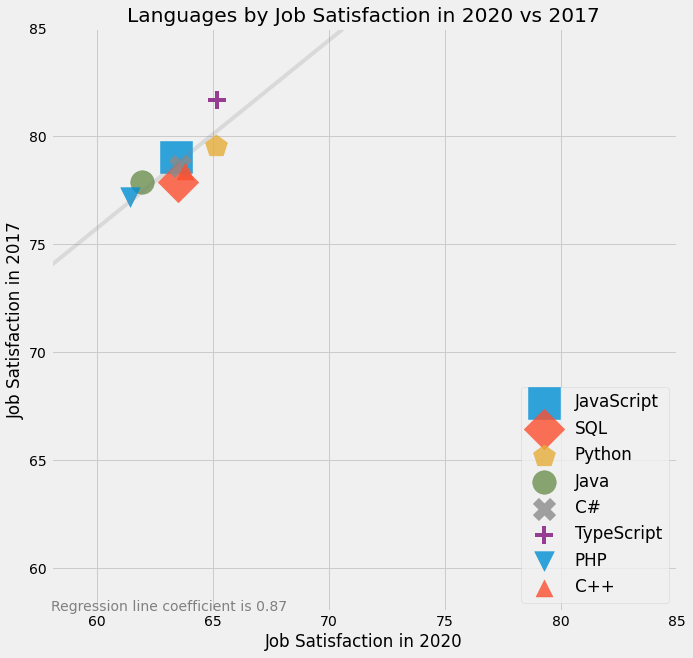

In [39]:
ljs_2020_total_top_10_for_2017 = ljs_2020_total_top_10.copy()
# None of 'HTML', 'CSS', 'Bash/Shell/PowerShell' in 2017 year's data
ljs_2020_total_top_10_for_2017 = ljs_2020_total_top_10_for_2017.drop(index=['HTML/CSS', 'Bash/Shell/PowerShell'])
language_job_satisfaction_2017_for_2020 = language_job_satisfaction_2017.copy()

plot_satisfaction_scatter(ljs_2020_total_top_10_for_2017, 
                          language_job_satisfaction_2017_for_2020.loc[ljs_2020_total_top_10_for_2017.index.tolist(), :], 
                          'Job Satisfaction in 2020', 'Job Satisfaction in 2017', 
                          'Languages by Job Satisfaction in 2020 vs 2017')